In [0]:
###############################################################################
# SETUP - EXECUTE THIS FIRST                                                  #
###############################################################################
# 1. Go into "Runtime" -> "Change runtime type" and Select "GPU" for hardward accelerator
# 2. Click the "Connect" button, at the right to start the instance.
# This will download the New York city travel dataset (small) from github
!wget https://github.com/nknewlands/DeepLearningShortCourse/raw/master/Day2/TimeSeries%20Anomaly/nyc_taxi.csv

--2019-08-15 05:51:56--  https://github.com/nknewlands/DeepLearningShortCourse/raw/master/Day2/TimeSeries%20Anomaly/nyc_taxi.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nknewlands/DeepLearningShortCourse/master/Day2/TimeSeries%20Anomaly/nyc_taxi.csv [following]
--2019-08-15 05:51:57--  https://raw.githubusercontent.com/nknewlands/DeepLearningShortCourse/master/Day2/TimeSeries%20Anomaly/nyc_taxi.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 265771 (260K) [text/plain]
Saving to: ‘nyc_taxi.csv’

nyc_taxi.csv        100%[===================>] 259.54K  --.-KB/s    in 0.02s   

2019-08-15 05:

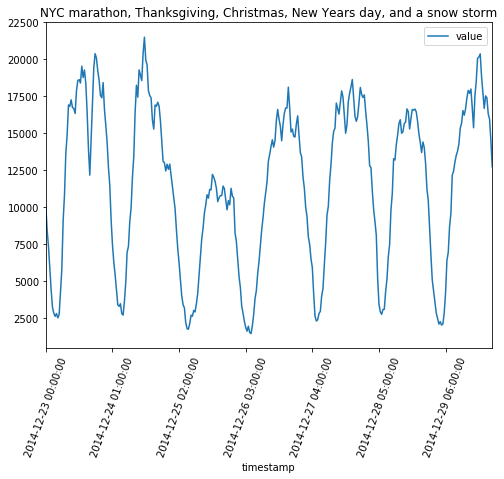

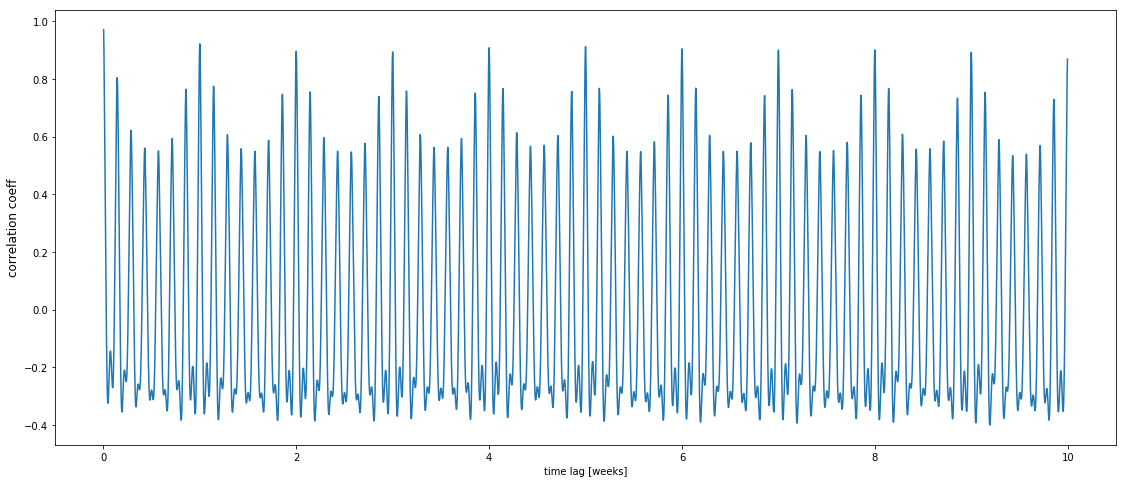

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 48, 1)        0                                            
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 48, 128)      33792       input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 32)           18560       bidirectional_9[0][0]            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 50)           1650        bidirectional_10[0][0]           
__________________________________________________________________________________________________
dense_18 (

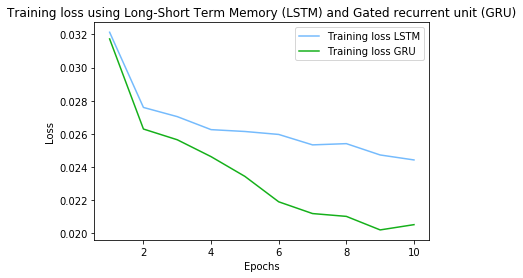

<Figure size 432x288 with 0 Axes>

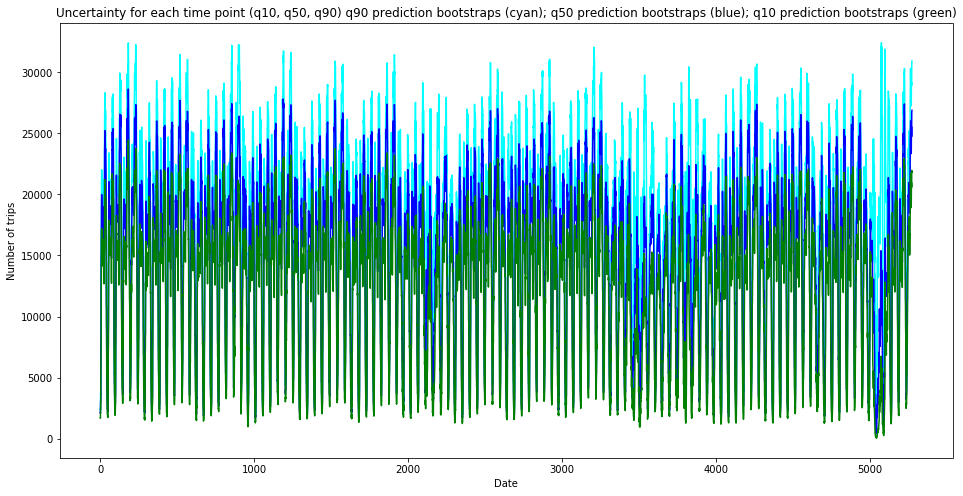

<Figure size 432x288 with 0 Axes>

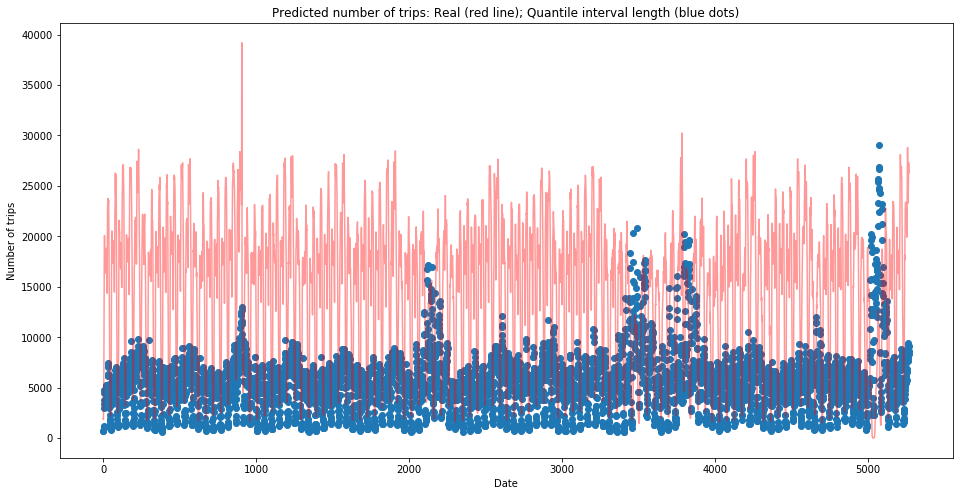

In [4]:
#!/usr/bin/python
#
# Annomaly detection in time series using LSTM
# Code and data from: https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Anomaly_Detection_LSTM/Anomaly_Detection_LSTM.ipynb
# See also: https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
# Modifications: Etienne Lord 2019
# Added GRU and other options
#
# Dataset represent the number of NY taxi trip each 30 minutes
#
###############################################################################
# GLOBAL IMPORT                                                               #
###############################################################################
from __future__ import absolute_import, unicode_literals, division, print_function
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import re
import datetime
from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda
from keras import backend as K

################################################################################ 
# LOAD  DATA                                                                   #
################################################################################
df = pd.read_csv('nyc_taxi.csv')

date = pd.DataFrame(np.vstack(df.timestamp.apply(lambda x: re.sub(r':|-' ,' ', x).split()))[:,:4].astype(int))

df = pd.concat([df, date], axis=1)
df.columns = ['timestamp','value','yr','mt','d','H']

## Plot a first view of the timeseries (one week 24 x 2 time points x 7 days) 
df.iloc[8400:8400+7*48,:].plot(title='NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm',y='value',x='timestamp',figsize=(8,6))

timeLags = np.arange(1,10*48*7)
autoCorr = [df.value.autocorr(lag=dt) for dt in timeLags]

## View a time lag analysis of the data
plt.xticks(rotation=70)
plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); plt.ylabel('correlation coeff', fontsize=12);
plt.show()
plt.savefig('timelag.png', bbox_inches='tight')

weekday = df[['yr', 'mt', 'd']].apply(lambda x: datetime.datetime(x['yr'], x['mt'], x['d']).weekday(),axis=1).values

df['weekday'] = weekday
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.H.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:5000].groupby('weekday_hour')['value'].mean().to_dict())

################################################################################ 
# LOAD  DATA                                                                   #
################################################################################
### CREATE GENERATOR FOR LSTM ###
sequence_length = 48 

def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

### CREATE AND STANDARDIZE DATA FOR LSTM ### 
cnt, mean = [], []
for sequence in gen_index(df, sequence_length, ['value']):
    cnt.append(sequence)
    
for sequence in gen_index(df, sequence_length, ['m_weekday']):
    mean.append(sequence)

cnt, mean = np.log(cnt), np.log(mean)
cnt = cnt - mean
cnt.shape

init = df.m_weekday[sequence_length:].apply(np.log).values
label = df.value[sequence_length:].apply(np.log).values - init
label.shape

### DEFINE QUANTILE LOSS ###
### See: https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)


X_train, X_test = cnt[:5000], cnt[5000:]
y_train, y_test = label[:5000], label[5000:]

losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]

################################################################################ 
# CREATE MODEL 1 - LSTM                                                        #
################################################################################

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True) #16
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)

model = Model(inputs, [out10,out50,out90])

model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
model.summary()

################################################################################ 
# CREATE MODEL 2 - GRU                                                         #
################################################################################

gru = Bidirectional(GRU(64, return_sequences=True, dropout=0.3))(inputs, training = True)
gru = Bidirectional(GRU(16, return_sequences=False, dropout=0.3))(gru, training = True) #16
dense2 = Dense(50)(gru)
out10_2 = Dense(1)(dense2)
out50_2 = Dense(1)(dense2)
out90_2 = Dense(1)(dense2)

model2=Model(inputs, [out10_2,out50_2,out90_2])
model2.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])
model2.summary()

################################################################################ 
# RUN BOTH MODELS                                                              #
################################################################################

epochs=10 # Number of training steps (should be ~100 or more)
history = model.fit(X_train, [y_train,y_train,y_train], epochs=epochs, batch_size=256, verbose=1, shuffle=True)
history2 = model2.fit(X_train, [y_train,y_train,y_train], epochs=epochs, batch_size=256, verbose=1, shuffle=True)

################################################################################ 
# VISUALIZE THE TRAINING RESULTS                                               #
################################################################################
loss = history.history['loss']
loss2=history2.history['loss']

epochs_len = range(1, len(loss) + 1)

# Colors are from are color from https://xkcd.com/color/rgb/
plt.clf()
plt.plot(epochs_len, loss, 'xkcd:sky blue', label='Training loss LSTM')
plt.plot(epochs_len, loss2, 'xkcd:green', label='Training loss GRU')
plt.title('Training loss using Long-Short Term Memory (LSTM) and Gated recurrent unit (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('models.png', bbox_inches='tight')

################################################################################ 
# VISUALIZE THE COMPUTED QUANTILE                                              #
################################################################################
### QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []
## Note: change model to model2 here for GRU
NN = K.function([model.layers[0].input, K.learning_phase()], 
                [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

for i in range(0,epochs):
    predd = NN([X_test, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init[5000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init[5000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init[5000:])

### EVALUATION METRIC ###
mean_squared_log_error(np.exp(y_test + init[5000:]), pred_50_m)

### PLOT QUANTILE PREDICTIONS ###
plt.clf()   # New figure
plt.figure(figsize=(16,8))
plt.plot(pred_90_m, color='cyan')
plt.plot(pred_50_m, color='blue')
plt.plot(pred_10_m, color='green')
plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
            pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50)
plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.title('Uncertainty for each time point (q10, q50, q90) q90 prediction bootstraps (cyan); q50 prediction bootstraps (blue); q10 prediction bootstraps (green)')
plt.show()
plt.savefig('quantile.png', bbox_inches='tight')

### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA (blue) ###
plt.clf()   # New figure
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_test + init[5000:]), color='red', alpha=0.4)
plt.scatter(range(len(pred_10_m)), pred_90_m - pred_10_m)
plt.title('Predicted number of trips: Real (red line); Quantile interval length (blue dots)')
plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.savefig('predicted.png', bbox_inches='tight')
plt.show()

################################################################################
# TO DO                                                                        #
################################################################################
#
# 1. Try to adjust the batch size and the number of epoch.
# 2. Try to add more LSTM layers or other memory cells.
# 3. Try to train on more data.
# 4. Can you identify one of the missing step?